## 1. Load NetCDF File

In [1]:
import netCDF4 as nc
import numpy as np
import os
filename='wout_QA_nfp2_A6.nc'
filepath=os.path.join(os.getcwd(), 'nc', filename)
f=nc.Dataset(filepath, 'r')

In [5]:
f.variables['xm_nyq'][:]

masked_array(data=[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                    1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
                    1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
                    2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
                    2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,
                    3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
                    3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,
                    4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
                    4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,
                    5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
                    5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,
                    6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
                    6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,
                    7.,  7.,  7.,  7.,

## 2. Define Functions to get parameters

In [3]:
nfp=f.variables['nfp'][0]
ns=f.variables['ns'][:].data
xn_nyq=f.variables['xn_nyq'][:].data
xm_nyq=f.variables['xm_nyq'][:].data
xn=f.variables['xn'][:].data
xm=f.variables['xm'][:].data
max_mnnyq=f.variables['mnmax_nyq'][:].data
max_mn=f.variables['mnmax'][:].data
phival=f.variables['phi'][:].data
def getsum_cos(coeff, m,n, s, theta, zeta):
    result = 0.0
    for idx in range(coeff.shape[1]):
        result+=coeff[s,idx]*np.cos(m[idx]*theta - n[idx]*zeta/nfp)
        
    return result
def getsum_sin(coeff, m,n, s, theta, zeta):
    result = 0.0
    for idx in range(coeff.shape[1]):
        result+=coeff[s,idx]*np.sin(m[idx]*theta - n[idx]*zeta/nfp)
        
    return result


def get_b(s, theta, zeta):
    b_coeff=f.variables['bmnc'][:].data
    return getsum_cos(b_coeff, xm_nyq, xn_nyq, s, theta, zeta)

def get_r(s, theta, zeta):
    r_coeff=f.variables['rmnc'][:].data
    return getsum_cos(r_coeff, xm, xn, s, theta, zeta)

def get_z(s, theta, zeta):
    z_coeff=f.variables['zmns'][:].data
    return getsum_sin(z_coeff, xm, xn, s, theta, zeta)

### 3. Plot abs(B) - 3D

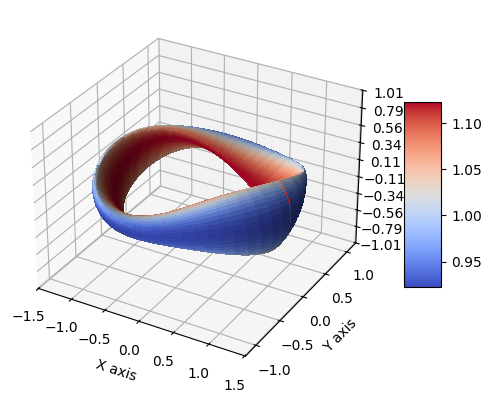

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# Make data.
zeta=np.arange(0,4*np.pi,np.pi/50)
theta=np.arange(0,2*np.pi,np.pi/50)
ZETA, THETA = np.meshgrid(zeta, theta)
R=get_r(ns-1, THETA, ZETA)
Z=get_z(ns-1, THETA, ZETA)
X=R*np.cos(ZETA/2)
Y=R*np.sin(ZETA/2)
B=get_b(ns-1, THETA, ZETA)

# 🔥 색 기준: X + Z
C = B
norm = plt.Normalize(C.min(), C.max())
colors = cm.coolwarm(norm(C))

# Plot the surface.
surf = ax.plot_surface(
    X, Y, Z,
    facecolors=colors,
    linewidth=0,
    antialiased=False
)

# z axis formatting
ax.set_zlabel('Z axis')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Color bar
mappable = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
mappable.set_array(C)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5)

plt.show()


### 4. Find minimum/Maximum

In [5]:
# compute max/min of get_b over theta,zeta for every s
# assumes np, get_b, nfp, ns are already defined in the notebook

ns_val = int(np.asarray(ns).item())   # number of radial surfaces
nfp_val = int(np.asarray(nfp).item())

theta_lin = np.linspace(0, 2*np.pi, 50)
zeta_lin  = np.linspace(0, 2*np.pi*nfp_val, 50)
ZETA, THETA = np.meshgrid(zeta_lin, theta_lin)  # shape (50,50)

results = []  # list of dicts with summary per s

for s in range(ns_val):
    Bgrid = get_b(s, THETA, ZETA)               # returns array/MaskedArray (50,50)
    arr = np.ma.filled(Bgrid, np.nan)           # convert masked -> nan for argmin/argmax

    # indices of extreme values
    imax_flat = np.nanargmax(arr)
    imin_flat = np.nanargmin(arr)
    imax = np.unravel_index(imax_flat, arr.shape)
    imin = np.unravel_index(imin_flat, arr.shape)

    max_val = arr[imax]
    min_val = arr[imin]

    theta_max = theta_lin[imax[0]]
    zeta_max  = zeta_lin[imax[1]]
    theta_min = theta_lin[imin[0]]
    zeta_min  = zeta_lin[imin[1]]

    results.append({
        "s": s,
        "max_val": float(max_val),
        "theta_max": float(theta_max),
        "zeta_max": float(zeta_max),
        "max_idx": imax,
        "min_val": float(min_val),
        "theta_min": float(theta_min),
        "zeta_min": float(zeta_min),
        "min_idx": imin
    })

# print a concise summary (first and last few entries)
print("Found extremes for {} s-values".format(ns_val))
for rec in results:
    print("s={s}: max={max_val:.6f} @ (theta={theta_max:.6f}, zeta={zeta_max:.6f}) | "
          "min={min_val:.6f} @ (theta={theta_min:.6f}, zeta={zeta_min:.6f})".format(**rec))
    print(f"phival={phival[rec['s']]}")


# also compute global extremes across all s
all_max = max(results, key=lambda r: r["max_val"])
all_min = min(results, key=lambda r: r["min_val"])
print("Global maximum: s={s}, value={max_val:.6f} at theta={theta_max:.6f}, zeta={zeta_max:.6f}".format(**all_max))

print("Global minimum: s={s}, value={min_val:.6f} at theta={theta_min:.6f}, zeta={zeta_min:.6f}".format(**all_min))

# results list remains available for further analysis / saving

Found extremes for 257 s-values
s=0: max=0.000000 @ (theta=0.000000, zeta=0.000000) | min=0.000000 @ (theta=0.000000, zeta=0.000000)
phival=-0.0
s=1: max=1.026212 @ (theta=0.000000, zeta=0.000000) | min=1.017224 @ (theta=3.077479, zeta=10.771175)
phival=0.00033984375
s=2: max=1.029408 @ (theta=0.000000, zeta=0.000000) | min=1.014007 @ (theta=3.077479, zeta=4.359761)
phival=0.0006796875
s=3: max=1.031605 @ (theta=0.000000, zeta=0.000000) | min=1.011794 @ (theta=3.077479, zeta=4.359761)
phival=0.00101953125
s=4: max=1.033391 @ (theta=0.000000, zeta=0.000000) | min=1.009994 @ (theta=3.077479, zeta=4.359761)
phival=0.001359375
s=5: max=1.034948 @ (theta=0.000000, zeta=3.077479) | min=1.008441 @ (theta=3.077479, zeta=4.359761)
phival=0.00169921875
s=6: max=1.036348 @ (theta=0.000000, zeta=3.077479) | min=1.007053 @ (theta=3.077479, zeta=4.359761)
phival=0.0020390625
s=7: max=1.037624 @ (theta=0.000000, zeta=3.077479) | min=1.005788 @ (theta=3.077479, zeta=4.359761)
phival=0.0023789062500000

### 5. Poloidal Crosssection

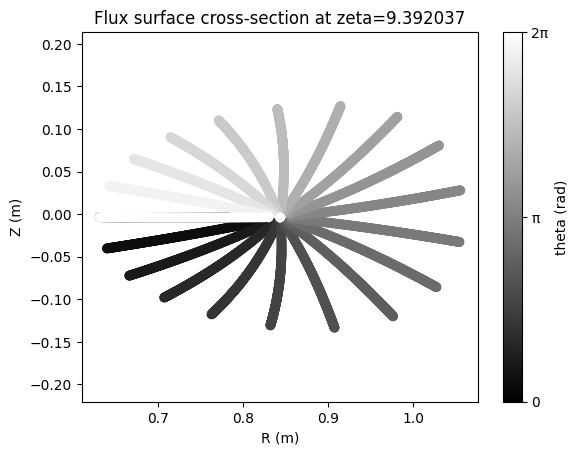

In [6]:
import matplotlib.pyplot as plt
import numpy as np

zeta = 9.392036731

s = np.array(range(ns))
theta = np.linspace(0, 2*np.pi, 20)

plt.figure()

# meshgrid
S, THETA = np.meshgrid(s, theta)

# 색 기준: THETA (0 ~ 2π)
C = THETA  

# r, z 계산
r_vals = get_r(S, THETA, zeta)
z_vals = get_z(S, THETA, zeta)

# scatter with theta-based coloring
sc = plt.scatter(r_vals, z_vals, c=C, cmap='gray')

# colorbar
cbar = plt.colorbar(sc)
cbar.set_label('theta (rad)')
cbar.set_ticks([0, np.pi, 2*np.pi])
cbar.set_ticklabels(['0', 'π', '2π'])

# axes labels
plt.xlabel('R (m)')
plt.ylabel('Z (m)')
plt.title('Flux surface cross-section at zeta={:.6f}'.format(zeta))
plt.axis('equal')

plt.show()
